# Exploratory Data Analysis of Reviews Data - EDA

The major objective of this notebook is to perform an Exploratory Data Analysis, also known as EDA, in the data related to games reviews. To do that, we start by joining our parquet files into a dataset. After, we ensure that each variable is in the correct format and start doing some simple explorations.

The structure of this notebook is as follows:

[0. Import Libraries](#libraries) <br>

# 0. Import Libraries<a id='libraries'></a>
[to the top](#top)  

The first step is to import the necessary libraries.
These imports cover the necessary libraries for working with Parquet files, data manipulation, visualization, and text preprocessing.

In [40]:
import pyarrow.parquet as pq
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk

# 1. Create Dataframe<a id='create'></a>
[to the top](#top)  

Our first step is to create a dataframe that as the information about all of our reviews. To do that we created a dataframe by joining our parquet files.

The cell bellow defines if we are going to create the datset from the parquet files (False) or if we are going to import it (True).

In [41]:
have_df = True

## 1.1. Join Parquets Function<a id='join'></a>
[to the top](#top)  

This function concatenates multiple Parquet files stored in a specified directory into a single DataFrame. It iterates through each Parquet file, reads it into a DataFrame, and appends the modified DataFrame to a list. Finally, it concatenates all DataFrames in the list into one, ensuring a unified dataset ready for further analysis or processing.

In [42]:
def concate_parquet(directory_path):

    # Get a list of Parquet files in the directory
    parquet_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.parquet')]

    # Initialize an empty list to store DataFrames
    dfs = []

    # Iterate through each Parquet file
    for file in parquet_files:
        # Read the Parquet file into a DataFrame
        df = pq.read_table(file).to_pandas()
        
        # Extract the substring before the underscore from the filename
        filename = os.path.basename(file)
        appid = filename.split('_')[0]
        
        # Append the modified DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into one
    concatenated_df = pd.concat(dfs, ignore_index=True)

    return concatenated_df


## 1.2. Join Parquets<a id='parquets_to_df'></a>
[to the top](#top)  

Next, we only have to indicate the directory for the parquet files and call the function.


In [43]:
if not have_df:
    parquets_df = concate_parquet('./data/parquets_preprocessed/')
    parquets_df

## 1.3. Expand column `author` Function<a id='exp_author'></a>
[to the top](#top)  

Because the column `author` was composed by dictionaries, our next step was to create new columns for the dataframe using the data in the dictionaries.


In [44]:
def expand_column(concatenated_df):
    # Use json_normalize to expand the dictionary column into separate columns
    expanded_df = pd.json_normalize(concatenated_df['author'])

    # Concatenate the expanded DataFrame with the original DataFrame
    result_df = pd.concat([concatenated_df, expanded_df], axis=1)

    # Drop the original dictionary column
    result_df.drop('author', axis=1, inplace=True)

    return result_df

## 1.4. Save Dataframe <a id='save'></a>
[to the top](#top)  

Lastly, we saved the dataframe so that we did not repeat this computational expensive process each time we run this notebook.

Below, we check if the `recommendationid` can be the index of the dataframe. Because it had duplicates, meaning the id was not unique, we did not use it as the index.

In [45]:
if not have_df:
    parquets_df['recommendationid'].duplicated().sum() # Cant be index

Below, we save the dataframe as a csv file.

In [46]:
if not have_df:
    parquets_df.to_csv('./data/parquets_df.csv', index=False)

Below, the dataset can simply be imported if it is already available.

In [47]:
if have_df:
    parquets_df = pd.read_csv("./data/parquets_df.csv")
    parquets_df

# 2. Exploratory Data Analysis - EDA <a id='eda'></a>
[to the top](#top)  

In this section, we start performing the Exploratory Data Analysis on the reviews dataset.

## 2.1. Basic Information Display<a id='basic_info'></a>
[to the top](#top)  

Below, we can see a concise summary of the DataFrame. This helps in understanding the structure of the data, identifying any issues such as missing values or incorrect data types, and getting an overall sense of the dataset.

In [48]:
# Display the basic information about the DataFrame
print("DataFrame Info:")
print(parquets_df.info())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3397339 entries, 0 to 3397338
Data columns (total 19 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   recommendationid             object        
 1   review                       object        
 2   timestamp_created            datetime64[us]
 3   timestamp_updated            datetime64[us]
 4   voted_up                     bool          
 5   votes_up                     int64         
 6   votes_funny                  int64         
 7   weighted_vote_score          float64       
 8   comment_count                int64         
 9   steam_purchase               bool          
 10  received_for_free            bool          
 11  written_during_early_access  bool          
 12  user_steamid                 object        
 13  user_num_games_owned         int64         
 14  user_num_reviews             int64         
 15  user_playtime_forever        floa

## 2.2. Check for Missing Values<a id='na'></a>
[to the top](#top) 

Understanding which columns have missing values helps in deciding how to handle them, such as filling them with appropriate values or dropping rows/columns.

In [49]:
# Check for missing values
print("\nMissing Values:")
print(parquets_df.isnull().sum()) # calculates the total number of missing values in each column of the DataFrame.


Missing Values:
recommendationid                     0
review                               0
timestamp_created                    0
timestamp_updated                    0
voted_up                             0
votes_up                             0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
user_steamid                         0
user_num_games_owned                 0
user_num_reviews                     0
user_playtime_forever                3
appid                                0
timestamp_dev_responded        3393009
developer_response             3393009
dtype: int64


## 2.3. Check for Duplicates<a id='duplicates'></a>
[to the top](#top) 

Duplicate rows should be addressed by either removing them or keeping them based on the context of the data.

In [50]:
parquets_df.duplicated().sum()

0

## 2.4. Numerical Variables<a id='num'></a>
[to the top](#top)

After, we isolate numerical variables from the DataFrame for further analysis.

In [58]:
# Select numerical variables
# Remove Id variables
numerical_df = parquets_df.select_dtypes(include=['int64', 'float64'])

### 2.4.1. Summary Statistics<a id='sum_stats'></a>
[to the top](#top)

Summary statistics provide insights into the central tendency, dispersion, and shape of the distribution of each numerical variable.

In [59]:
# Get to know the dataset
numerical_df.describe().T

,count,mean,std,min,25%,50%,75%,max
votes_up,3397339.0,2.533104e+00,6.293191e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.399300e+04
votes_funny,3397339.0,4.804089e+04,1.436415e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.294967e+09
weighted_vote_score,3397339.0,1.728950e-01,2.456930e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.919679e-01,9.929510e-01
comment_count,3397339.0,1.088840e-01,2.706021e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.516000e+03
user_num_games_owned,3397339.0,1.099910e+02,3.458509e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.010000e+02,3.090800e+04
user_num_reviews,3397339.0,1.733508e+01,7.957305e+01,1.000000e+00,2.000000e+00,6.000000e+00,1.500000e+01,1.150200e+04
user_playtime_forever,3397336.0,2.031616e+04,5.759867e+04,0.000000e+00,1.853000e+03,6.168000e+03,1.647900e+04,4.201472e+06
timestamp_dev_responded,4330.0,1.606395e+09,7.907473e+07,1.434561e+09,1.516320e+09,1.626688e+09,1.679490e+09,1.715623e+09


### 2.4.2. Correlation Matrix<a id='cm'></a>
[to the top](#top)

After, we crreated a corrolation matrix to explore the linear relationship between pairs of numerical variables in the DataFrame. It helps in understanding how variables are related to each other, which can guide feature selection, dimensionality reduction, or predictive modeling.

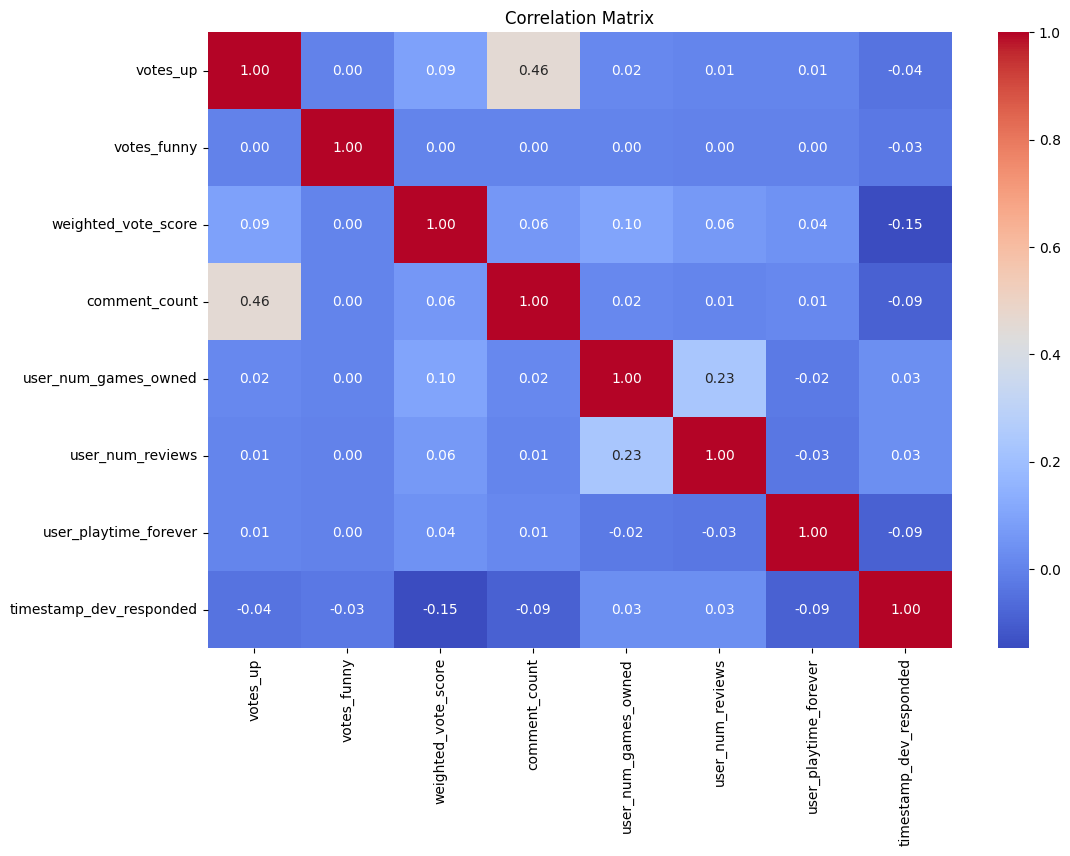

In [60]:
# Calculate correlations between numerical columns
correlation_matrix = numerical_df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


The heatmap produced visually represents the strength and direction of the linear relationship between pairs of numerical variables. Correlation coefficients close to 1 indicate a strong positive linear relationship, while coefficients close to -1 indicate a strong negative linear relationship. Coefficients close to 0 suggest little to no linear relationship.
High correlations (either positive or negative) between variables may indicate redundancy or multicollinearity, which can affect the performance of predictive models.

### 2.4.3. Scatter Matrix of User's Data<a id='sm_users'></a>
[to the top](#top)

After, we visualize relationships between multiple numerical variables in the user's data. The scatter matrix provides a comprehensive view of pairwise relationships between variables, along with histograms of individual variables along the diagonal.

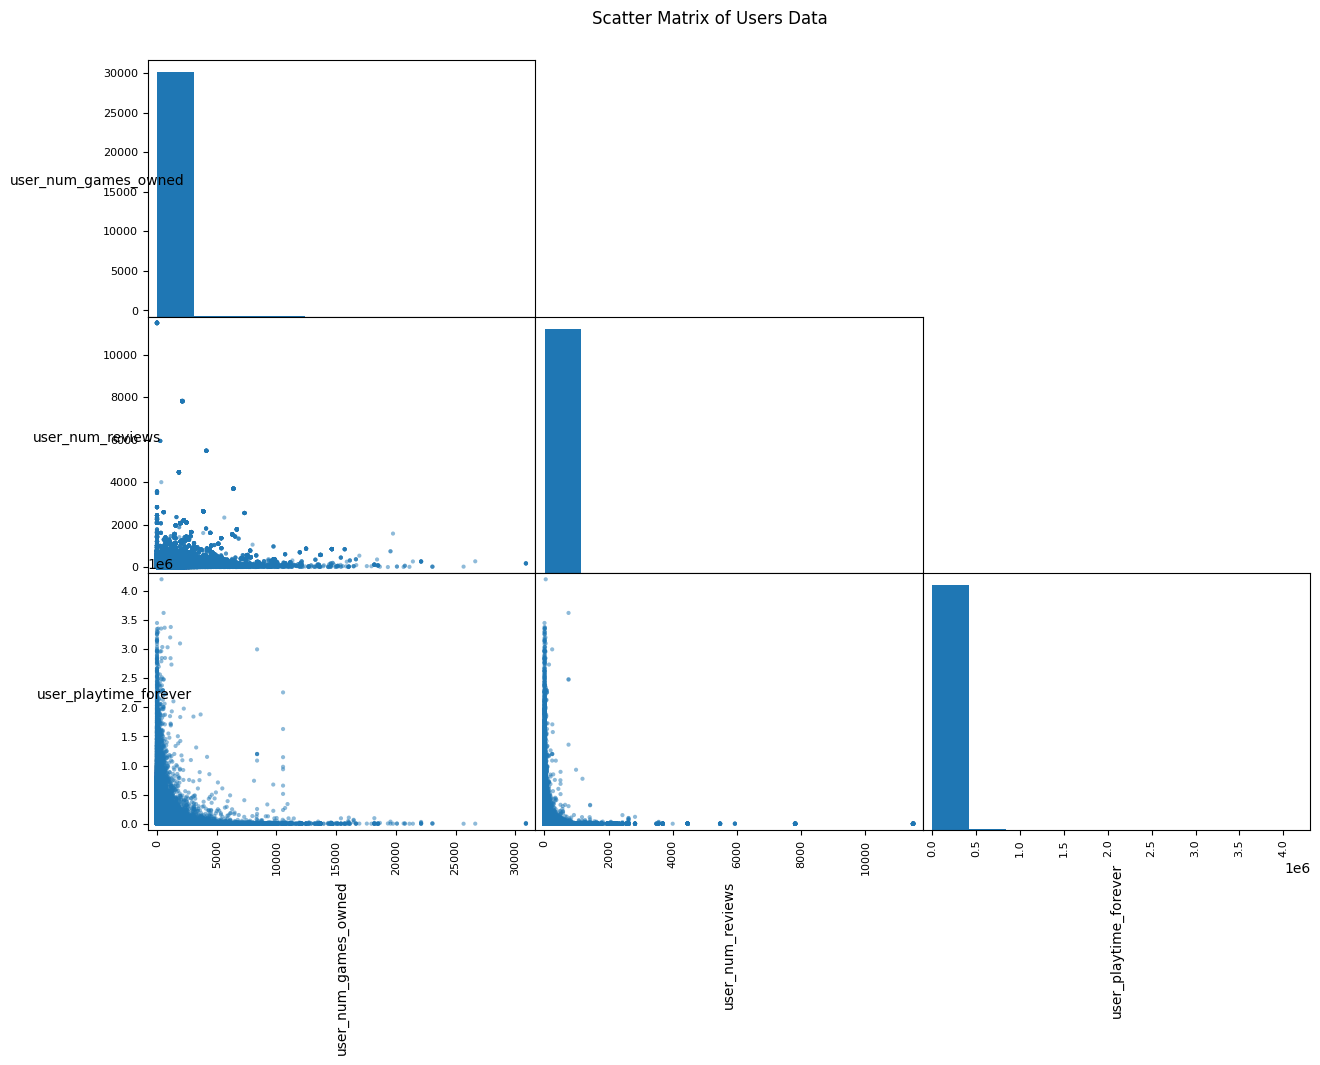

In [61]:
# Create a scatter matrix
scattermatrix = scatter_matrix(parquets_df[['user_num_games_owned', 'user_num_reviews', 'user_playtime_forever']],
                                diagonal='hist', figsize=(15,10))

# Get the number of columns in the matrix
n = scattermatrix.shape[1]

# Mask the upper triangle of the matrix
for i in range(n):
    for j in range(i + 1, n):
        scattermatrix[i, j].set_visible(False)
        
# Rotate the axis labels
for ax in scattermatrix.ravel():    
    ax.yaxis.label.set_rotation(0)
    ax.xaxis.label.set_rotation(90)

# Choose a title and make the title appear closer to the graph
plt.suptitle("Scatter Matrix of Users Data", y = 0.93)
    
# Show the plot
plt.show()

### 2.4.4. Scatter Matrix of Reviews' Data<a id='sm_reviews'></a>
[to the top](#top)

Below, we can visualize relationships between multiple numerical variables in the reviews' data. Similar to the previous scatter matrix, this visualization provides insights into pairwise relationships between variables and their distributions.

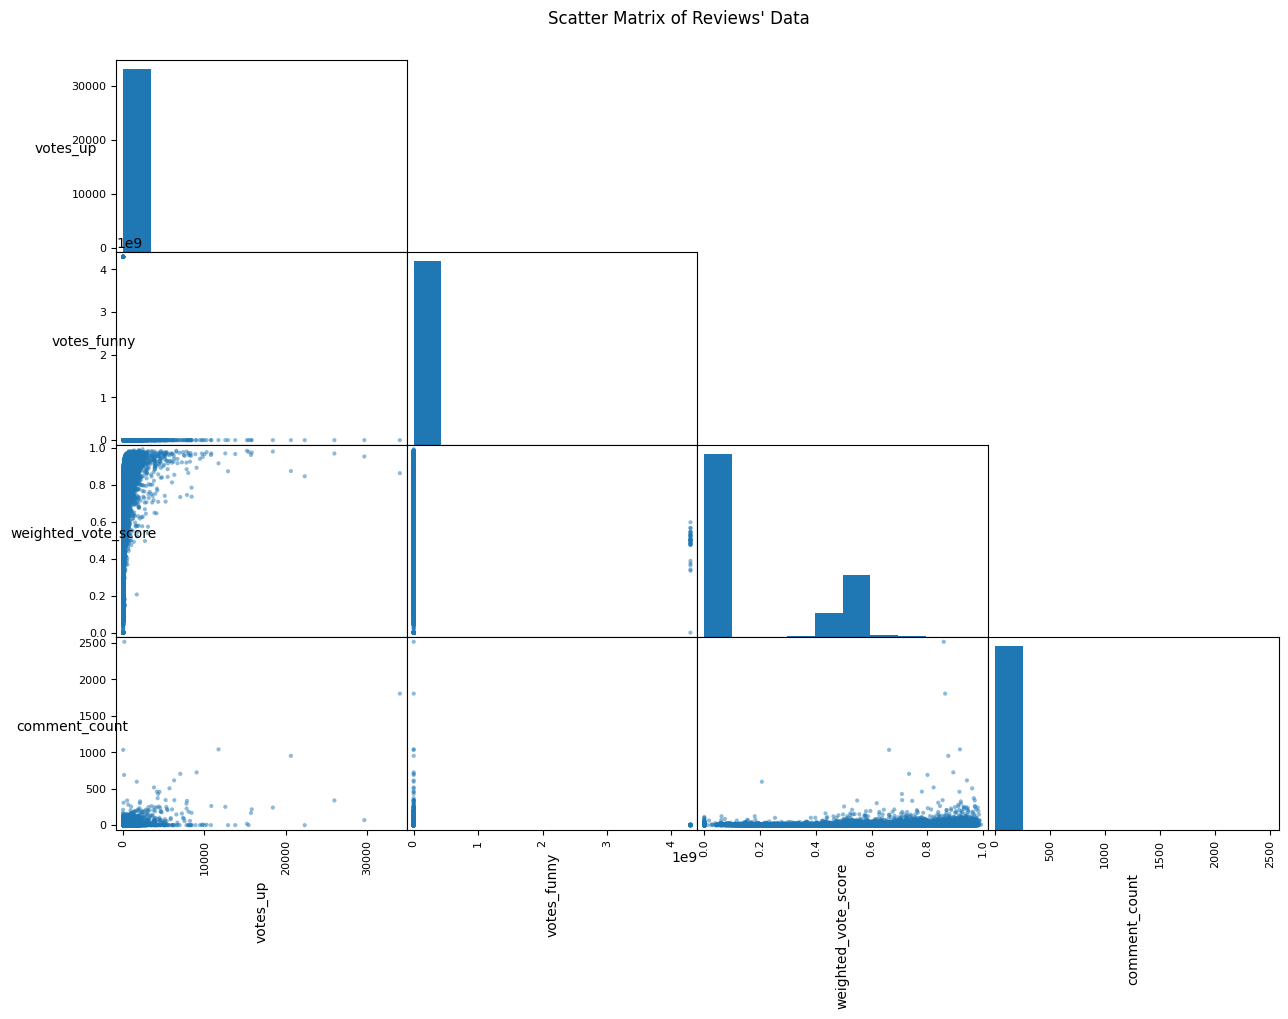

In [62]:
# Create a scatter matrix
scattermatrix = scatter_matrix(parquets_df[['votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count']],
                                diagonal='hist', figsize=(15,10))

# Get the number of columns in the matrix
n = scattermatrix.shape[1]

# Mask the upper triangle of the matrix
for i in range(n):
    for j in range(i + 1, n):
        scattermatrix[i, j].set_visible(False)
        
# Rotate the axis labels
for ax in scattermatrix.ravel():    
    ax.yaxis.label.set_rotation(0)
    ax.xaxis.label.set_rotation(90)

# Choose a title and make the title appear closer to the graph
plt.suptitle("Scatter Matrix of Reviews' Data", y = 0.93)
    
# Show the plot
plt.show()

### 2.4.5. Voted Up vs. Voted Down Reviews<a id='up_down'></a>
[to the top](#top)

Here, we can visualize the distribution of reviews based on whether they were voted up or down by users, providing an overview of user sentiment towards the reviewed content.

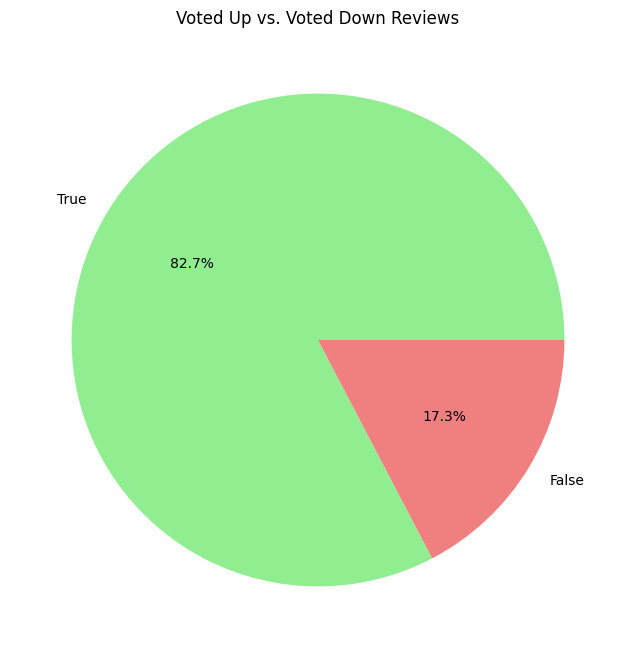

In [63]:
# Pie Chart of Voted Up vs. Voted Down Reviews
voted_counts = parquets_df['voted_up'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(voted_counts, labels=voted_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Voted Up vs. Voted Down Reviews')
plt.show()

A larger portion of reviews in the "Voted Up" category suggests that the majority of users have positive sentiments towards the reviewed content.

## 2.5. Time-Based Variables<a id='time'></a>
[to the top](#top)

Our next step, was to analyse variables related to timestamps.

### 2.5.1. Time-series of the Quantity of Reviews<a id='ts_reviews'></a>
[to the top](#top)

Below, we can visualize the distribution of the timestamp_created variable, which represents the time when reviews were created. Understanding the distribution of timestamps can provide insights into temporal patterns or trends in review creation.

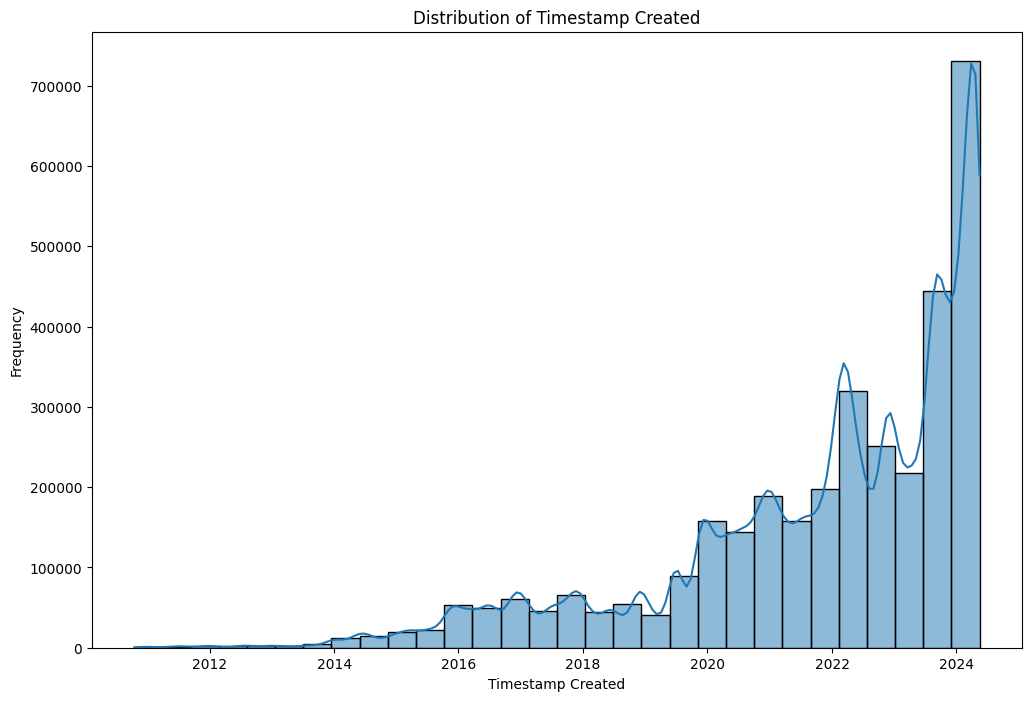

In [64]:
# Distribution of timestamp_created
plt.figure(figsize=(12, 8))
sns.histplot(data=parquets_df['timestamp_created'], bins=30, kde=True)
plt.title("Distribution of Timestamp Created")
plt.xlabel("Timestamp Created")
plt.ylabel("Frequency")
plt.show()

Peaks in the distribution indicate periods of high review activity.

### 2.5.2. Filtered Distribution of Timestamp Created (2020-2024)<a id='ts_interval'></a>
[to the top](#top)

After, we filter the data for timestamps between 2020 and 2024 and visualize the distribution of review creation timestamps during this period Additionally, we created another plot to analyze the distribution of game contributions (reviews) for each game during the same period.

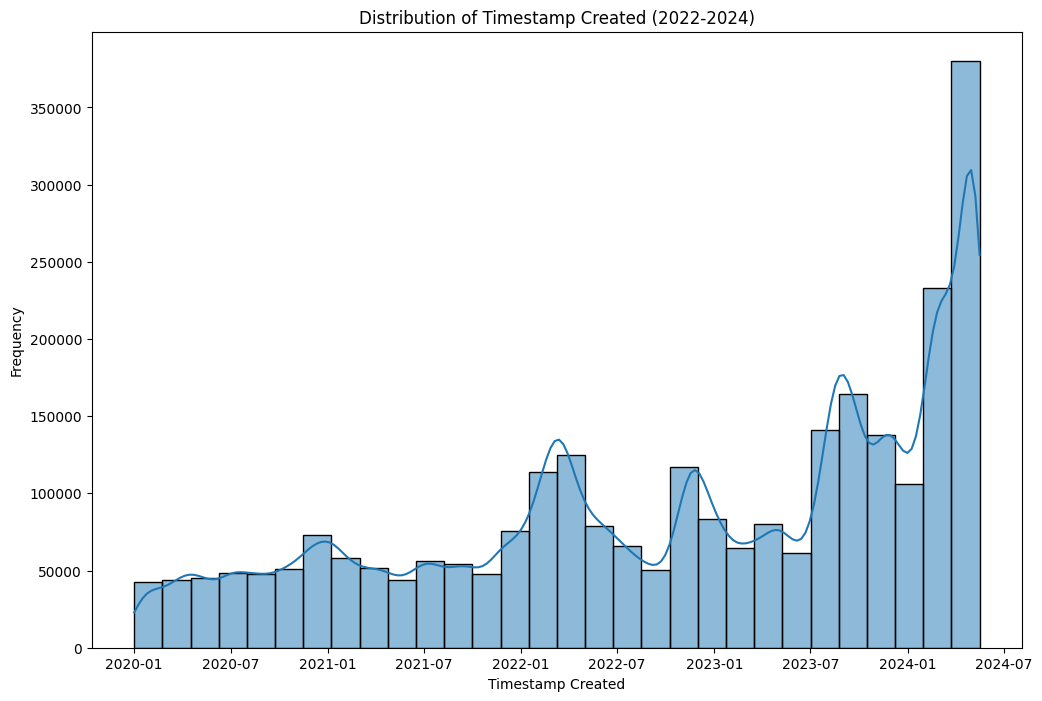

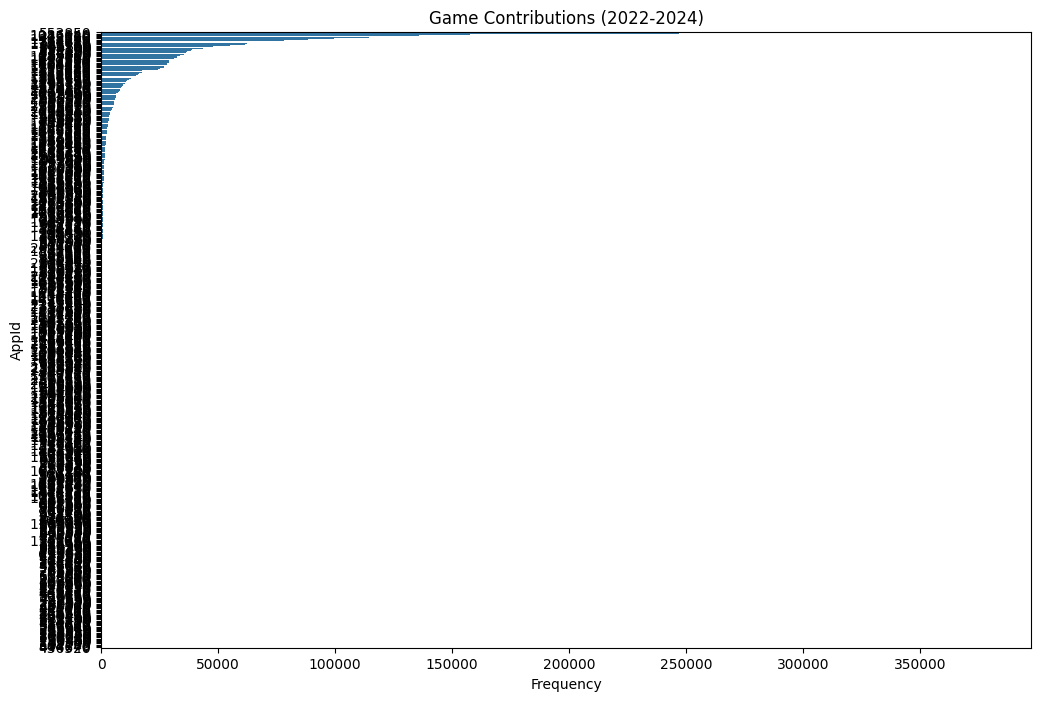

In [67]:
# Filter the data for timestamps between 2020 and 2024 - Change dates using the peaks of the data
start_date = '2020-01-01'
end_date = '2024-12-31'
filtered_df = parquets_df[(parquets_df['timestamp_created'] >= start_date) & (parquets_df['timestamp_created'] <= end_date)]

# Plot the distribution of timestamp_created between 2022 and 2024
plt.figure(figsize=(12, 8))
sns.histplot(data=filtered_df['timestamp_created'], bins=30, kde=True)
plt.title("Distribution of Timestamp Created (2022-2024)")
plt.xlabel("Timestamp Created")
plt.ylabel("Frequency")
plt.show()

# Plot the distribution of game contributions in the same period
plt.figure(figsize=(12, 8))
sns.countplot(data=filtered_df, y='appid', order=filtered_df['appid'].value_counts().index)
plt.title("Game Contributions (2022-2024)")
plt.xlabel("Frequency")
plt.ylabel("AppId")
plt.show()

The first plot visualizes the frequency distribution of review creation timestamps between 2022 and 2024. This helps in identifying any temporal patterns or trends in review activity during this period.
The second plot displays the distribution of game contributions (reviews) for each game during the same period, allowing for the identification of popular games or those with the highest number of reviews.

### 2.5.3. Monthly Count of Voted Up Reviews<a id='ts_votesUp'></a>
[to the top](#top)

Following, we perform time series analysis on the count of "voted up" reviews over monthly intervals, this helps in understanding patterns, trends, and seasonality in the data over time.

C:\Users\abdar\AppData\Local\Temp\ipykernel_15828\3617703486.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  parquets_df['voted_up'].resample('M').count().plot()


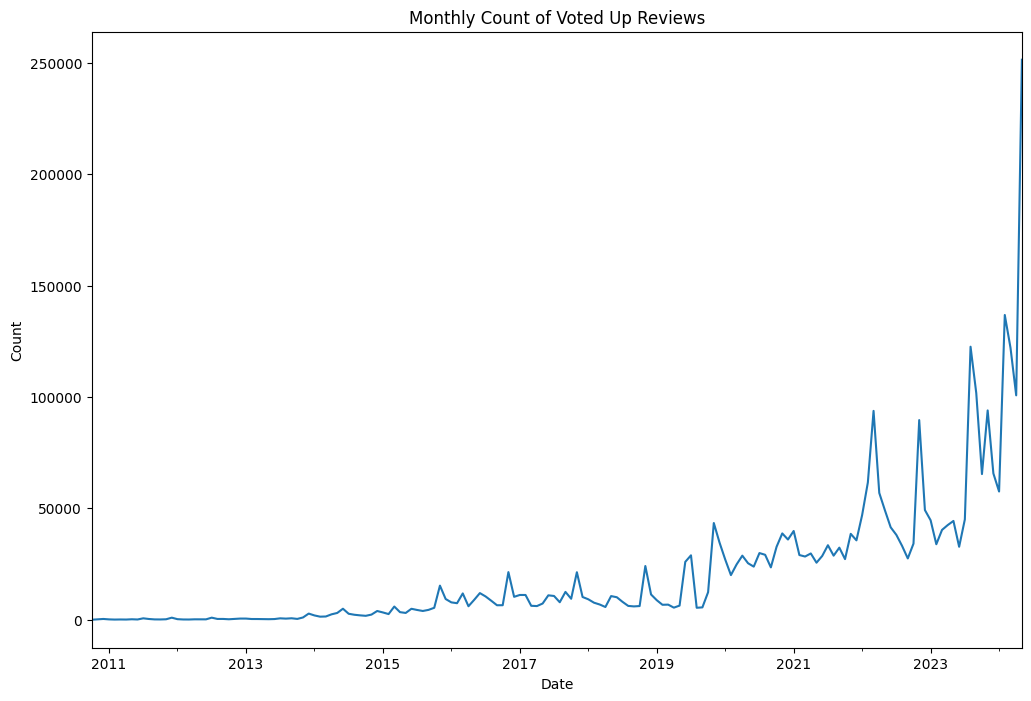

In [68]:
# Time series analysis
parquets_df.set_index('timestamp_created', inplace=True)
plt.figure(figsize=(12, 8))
parquets_df['voted_up'].resample('M').count().plot()
plt.title("Monthly Count of Voted Up Reviews")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

## 2.6. Reviews Analysis<a id='reviews'></a>
[to the top](#top)

In this next subsection, we decided to focus on the feature `reviews`.

### 2.6.1. Reviews with "EDIT:" <a id='edit'></a>
[to the top](#top)

Here filter reviews that start with "EDIT:" and check how many of the reviews were edited.

In [71]:
# Filter reviews that start with "EDIT:"
edit_reviews = parquets_df[parquets_df['review'].str.startswith('EDIT:')]
print(len(edit_reviews))

1716


The count of reviews that start with "EDIT:" provides insights into the frequency of edited reviews, which may indicate user interactions or updates to previous reviews

### 2.6.2. Review Length Histogram<a id='edit'></a>
[to the top](#top)


To visualize the distribution of review lengths using a histogram.

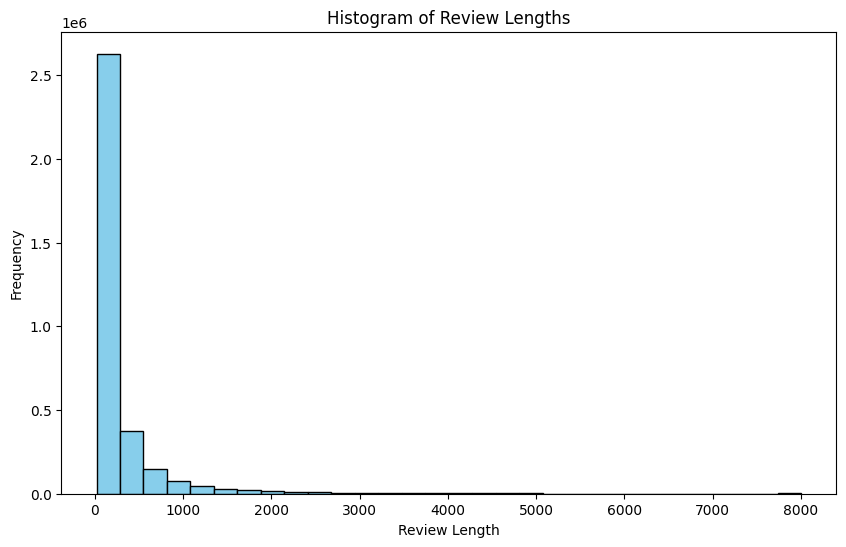

In [72]:
# Histogram of Review Lengths
parquets_df['review_length'] = parquets_df['review'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(parquets_df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

The histogram of review lengths visualizes the distribution of review lengths, allowing for the identification of common or uncommon review lengths and their frequencies.

### 2.6.3. Preprocessing Reviews<a id='preprocessing'></a>
[to the top](#top)

After, we preprocess text data by removing noise and irrelevant information, making it suitable for natural language processing tasks such as sentiment analysis or text classification.

In [73]:
def preprocess_text(text):
    '''Takes a string as input and returns a preprocessed string as output'''
    
    #remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)

    #lowercase
    text = [word.lower() for word in text]
    
    #remove stopwords
    stop_words = stopwords.words('english')
    text = [word for word in text if word not in stop_words]
    
    #remove numbers
    text = [word for word in text if word.isalpha()]

    # Join
    text = ' '.join(text)

    #remove isolated consonants:
    text = re.sub(r'\b([^aeiou-])\b',' ',text)

    return text

In [76]:
# Apply the preprocess_text function to each sentence in the DataFrame
parquets_df['review_preprocessed'] = parquets_df['review'].apply(preprocess_text)

### 2.6.4. Sentiment Analysis<a id='sa'></a>
[to the top](#top)

Here, we calculate the sentiment polarity of each review using VADER, visualize the distribution of review sentiment polarity and explore its relationship with the number of votes up.

In [77]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity using VADER
def get_vader_sentiment(review):
    return sid.polarity_scores(review)['compound']

# Calculate sentiment polarity for each review
parquets_df['sentiment'] = parquets_df['review_preprocessed'].apply(get_vader_sentiment)

# Distribution of Sentiment
plt.figure(figsize=(18, 6))  # Changed the width to 18 for a wider plot
sns.histplot(parquets_df['sentiment'], bins=30, kde=True, color='purple')
plt.title('Distribution of Review Sentiment')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Sentiment vs. Votes Up
plt.figure(figsize=(18, 6))  # Changed the width to 18 for a wider plot
sns.scatterplot(x='sentiment', y='votes_up', data=parquets_df, alpha=0.5)
plt.title('Sentiment vs. Votes Up')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Votes Up')
plt.show()

The histogram provides insights into the distribution of sentiment polarity across all reviews, indicating the prevalence of positive, negative, or neutral sentiments.
The scatter plot explores the relationship between sentiment polarity and the number of votes up, allowing for the examination of any patterns or correlations between review sentiment and user engagement.

### 2.6.5. Word Cloud<a id='word_cloud'></a>
[to the top](#top)

### Word Cloud Visualization of Preprocessed Text Data
To visually explore the most frequent words in the preprocessed text data, providing insights into the common themes or topics present in the reviews.

In [ ]:
# Join the preprocessed sentences into a single string
wordcloud_input = ' '.join(parquets_df['review_preprocessed'])

# Create a wordcloud
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                max_font_size = 50, 
                colormap='Dark2').generate(wordcloud_input)

# Plot the WordCloud image
plt.figure(figsize = (8, 6), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

KeyboardInterrupt: 

The word cloud allows for a quick understanding of the predominant themes or topics present in the reviews.
Words that appear larger and more prominently in the word cloud are those that occur frequently across multiple reviews.
Analyzing the word cloud can reveal insights into the sentiments, preferences.